In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

from collections import Counter
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold

from datetime import date, datetime

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# functions required to perform basic transformations
# these transformations can be safely applied to all the data set (inc validation)
# because they only take into consideration the values of the current row

# function to translate gender into 
def get_gender(_input):
    if 'Female' in _input:
        return 'F'
    elif 'Male' in _input:
        return 'M'
    else:
        return 'U'

# function that returns 1 if animal was operated; 0 otherwise
def is_operated(_input):    
    return int(_input.split()[0] in ['Neutered', 'Spayed'])   

# Transform ages to categoris as follows:
# 1 = neonatal; 2 = infant; 3 = child; 4 = adolescent; 5 = young_adult; 6 = mature_adult; 7 = old
# These categories are based on rate that animal ages w.r.t. human years and the stages of human development
# https://www.ajdesigner.com/fl_cat_age/cat_age.php; https://pets.webmd.com/dogs/how-to-calculate-your-dogs-age
def get_age_in_labels(_input):
    age_label = 0
    age_list = _input.split()
    age = int(age_list[0])
    if "year" in age_list[1]:
        # 
        options = [4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7]
        age = age - 1 if age < 11 else 10
        age_label = options[age]        
    elif "month" in age_list[1]:
        options = [2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]
        age_label = options[age-1]
    elif "week" in age_list[1]:        
        age_label = 1
    else:
        # if less than 1 week, default to 1 week
        age_label = 1
    return age_label

# this function returns purity category: "pure", "mixed", "cross"
# depending on whether breed string features just the animal breed, the word "mix" or a fwd-slash
def get_breed_purity(_input):
    breed_purity = ""
    if "/" in _input:
        breed_purity = "cross"
    elif "Mix" in _input:
        breed_purity = "mix"
    else:
        breed_purity = "pure"
    return breed_purity

# code to determine season from: https://stackoverflow.com/a/28688724
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)


In [153]:
# import training data in pandas dataframe df
df = pd.read_csv('train.csv', header=0, sep=",")
# print columns having at least one null entry
#print df.isnull().any()
# only 1 case of unknown sex
df[df["SexuponOutcome"].isnull() == True]
# only 18 cases of unknown age
len(df[df["AgeuponOutcome"].isnull() == True])
# remove null cases 

# remove null ages
df = df[~df['AgeuponOutcome'].isnull()]
df = df[~df['SexuponOutcome'].isnull()]
#print df.isnull().any()

# there are 22 cases where Age is 0 years; the distribution of outcomes (compared to the cases where age is known)
# strongly suggests that these animals are neonatal.  Defaulting the value to 1 week
print df[(df.AgeuponOutcome == '0 years')]["OutcomeType"].value_counts()
df.loc[df.AgeuponOutcome == '0 years', 'AgeuponOutcome'] = "1 week"


Transfer      19
Euthanasia     2
Died           1
Name: OutcomeType, dtype: int64


In [154]:
# we are going to perform dummy converstion, label encoding prior to splitting
# replace missing value with "Unknown"

df["HasName"] = (~df.loc[:,"Name"].isnull()).apply(lambda x: int(x))
df["IsOperated"] = df["SexuponOutcome"].apply(is_operated)
df["Gender"] = df["SexuponOutcome"].apply(get_gender)
df["AgeCategory"] = df["AgeuponOutcome"].apply(get_age_in_labels)
df["BreedPurity"] = df["Breed"].apply(get_breed_purity).astype('category')
df["IsWeekend"] = pd.to_datetime(df.DateTime).apply(lambda x: int(1  if x.weekday() in [5,6] else 0))
df["Season"] = pd.to_datetime(df.DateTime).apply(get_season)

df = pd.get_dummies(df, columns=['AnimalType', 'Gender', 'BreedPurity', 'Season'], drop_first=True)
#df = pd.get_dummies(df, columns=['AnimalType', 'Gender', 'BreedPurity', 'Season', 'AgeCategory'], drop_first=True)

# features that will be used to build our model
# HasName, AnimalType_Dog, Gender, is_operated, 
# lets start with a simple model that ignores the breed and color
# we will then build a more complex model that features TFID terms 

In [164]:
# Display columns to make selection easier
ids = range(len(df.columns))
[(x, df.columns[x]) for x in ids]

[(0, 'AnimalID'),
 (1, 'Name'),
 (2, 'DateTime'),
 (3, 'OutcomeType'),
 (4, 'OutcomeSubtype'),
 (5, 'SexuponOutcome'),
 (6, 'AgeuponOutcome'),
 (7, 'Breed'),
 (8, 'Color'),
 (9, 'HasName'),
 (10, 'IsOperated'),
 (11, 'AgeCategory'),
 (12, 'IsWeekend'),
 (13, 'AnimalType_Dog'),
 (14, 'Gender_M'),
 (15, 'Gender_U'),
 (16, 'BreedPurity_mix'),
 (17, 'BreedPurity_pure'),
 (18, 'Season_spring'),
 (19, 'Season_summer'),
 (20, 'Season_winter')]

In [181]:
df.iloc[2:5,[9,10,11,12,14,15,16,17,18,19,20]]

,HasName,IsOperated,AgeCategory,IsWeekend,Gender_M,Gender_U,BreedPurity_mix,BreedPurity_pure,Season_spring,Season_summer,Season_winter
2,1,1,5,1,1,0,1,0,0,0,1
3,0,0,1,0,1,0,1,0,0,1,0
4,0,1,5,0,1,0,0,0,0,0,0


In [177]:
# create feature and label array
X = df.iloc[:, 9:].values
y = df.iloc[:, 3].values
# build dog model
#X = df[df.AnimalType_Dog==1].iloc[:, 9:]
#y = df[df.AnimalType_Dog==1].iloc[:, 3]
print X.shape
print y.shape

# convert target variable to number
le = LabelEncoder()
y = le.fit_transform(y)
# we can compute inverse_transform to get back the labels
le.inverse_transform(y)

# split in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


(26710, 12)
(26710,)


In [178]:
from collections import Counter
_foo = Counter(y_test), Counter(y_train)

# confirm that propotion of test outcome is similar to population proportion
print [float(_foo[0][x])/float(sum(_foo[0].values())) * 100. for x in _foo[0]]

# confirm that propotion of train outcome is similar to population proportion
print [float(_foo[1][x])/float(sum(_foo[1].values())) * 100. for x in _foo[1]]


[40.90228378884313, 0.6926244852115313, 6.027704979408461, 17.57768625982778, 34.79970048670909]
[40.17222014226881, 0.7487832272557094, 5.760950954698615, 17.998876825159115, 35.31916885061774]


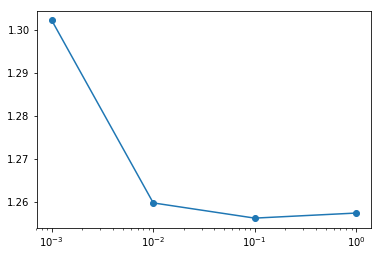

In [179]:
number_classes = len(le.classes_)

# return log loss for various regularisation C values over stratified folds
def score(clf, random_state = 0):
    kf = StratifiedKFold(y_train, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y_train.shape[0], number_classes))
    for train, test in kf:
        X_train_tr, X_train_test = X_train[train, :], X_train[test, :]
        y_train_tr, y_train_test = y[train], y[test]
        clf.fit(X_train_tr, y_train_tr)
        pred[test,:] = clf.predict_proba(X_train_test)        
        return log_loss(y_train_test, pred[test, :])        
    return log_loss(y_train, pred)

Cs = np.logspace(-3,0,4)
res = []
for c in Cs:
    res.append(score(LogisticRegression(penalty='l1', C = c, random_state=0)))
plt.semilogx(Cs, res,'-o');
plt.show()


In [172]:
lr = LogisticRegression(penalty='l1', C=0.1, random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [173]:
#print X_test[0,:].reshape(-1,12)
print lr.predict_proba(X_test)
#lr.predict_proba(X_test[0,:].reshape(-1,12))
print y_test[0]
print lr.score(X_train, y_train)
print lr.score(X_test, y_test)

[[ 0.01926844  0.00548269  0.31119028  0.07859673  0.58546187]
 [ 0.1182259   0.03021588  0.06174012  0.0191293   0.77068882]
 [ 0.29371086  0.00099447  0.05969353  0.48176944  0.16383169]
 ..., 
 [ 0.72550071  0.00287516  0.00626716  0.12987695  0.13548003]
 [ 0.46321467  0.00149707  0.03948306  0.32530011  0.17050509]
 [ 0.56174545  0.00210934  0.00951878  0.23696093  0.1896655 ]]
4
0.572550905884
0.579352356525


In [174]:
from sklearn.metrics import log_loss
predictions = lr.predict_proba(X_test)
print log_loss(y_test, predictions)
print lr.coef_

print df.columns[9:]
print le.classes_
df.iloc[:,9:].head()

1.0109679479
[[ -1.02626719e-01   3.76864558e+00  -5.17166052e-01   5.71395089e-01
   -3.61359018e-01  -2.21880208e-01   0.00000000e+00  -1.72732901e-01
   -3.67999189e-01  -2.16286595e-02   2.24208843e-01   1.59115141e-01]
 [ -3.85342823e-01  -1.03828660e+00  -3.98218193e-01   0.00000000e+00
   -1.17109519e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -8.97160369e-01  -1.76181298e+00   5.51563724e-01  -5.20524357e-01
   -2.07116178e+00   1.06096928e-01   0.00000000e+00   0.00000000e+00
   -3.24459940e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.89263475e+00  -2.79568744e-01   4.61585896e-01  -2.59803841e-01
   -2.39987386e+00   1.57847343e-01   0.00000000e+00   1.90324217e-01
    1.99772684e-01   9.77601474e-02  -1.61394672e-01  -2.90200068e-03]
 [ -6.85455919e-01  -1.47922005e+00  -9.93785465e-02  -2.38056499e-01
    4.29586344e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   

,HasName,IsOperated,AgeCategory,IsWeekend,AnimalType_Dog,Gender_M,Gender_U,BreedPurity_mix,BreedPurity_pure,Season_spring,Season_summer,Season_winter
0,1,1,4,0,1,1,0,1,0,0,0,1
1,1,1,4,1,0,0,0,1,0,0,0,0
2,1,1,5,1,1,1,0,1,0,0,0,1
3,0,0,1,0,0,1,0,1,0,0,1,0
4,0,1,5,0,1,1,0,0,0,0,0,0
